[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on JSON Data Extraction Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Tue Mar  4 16:13:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [4]:
!pip install -q supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("pallet-load-manifest-json")
version = project.version(2)
dataset = version.download("jsonl")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pallet-load-manifest-json-2 in jsonl:: 100%|██████████| 178/178 [00:00<00:00, 5091.01it/s]


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!head -n 5 /content/drive/MyDrive/finetune-Qwen2-VL/output1.jsonl

{"image": "/content/drive/MyDrive/Small_human_extracted/Images/Train/CXR1_IM-0001-4001.png, /content/drive/MyDrive/Small_human_extracted/Images/Train/CXR1_IM-0001-3001.png", "prefix": "Describe the findings in X-ray images", "suffix": "the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. normal chest x-xxxx."}
{"image": "/content/drive/MyDrive/Small_human_extracted/Images/Train/CXR3_IM-1384-1001.png, /content/drive/MyDrive/Small_human_extracted/Images/Train/CXR3_IM-1384-2001.png", "prefix": "Describe the findings in X-ray images", "suffix": "no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified."}
{"image": "/content/drive/MyDrive/Small_human_extracted/Images/Train/CXR7_IM-2263-1001.png, /con

### Set up and test data loaders

In [7]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]

        # Assuming the image paths in the JSON file are in a list or a comma-separated format.
        image_paths = entry['image'].split(', ')

        # Load the two images
        images = [Image.open(os.path.join(self.image_directory_path, path)) for path in image_paths]

        return images, entry


In [8]:
train_dataset = JSONLDataset(
    jsonl_file_path="/content/drive/MyDrive/finetune-Qwen2-VL/output1.jsonl",
    image_directory_path="",
)
valid_dataset = JSONLDataset(
    jsonl_file_path="/content/drive/MyDrive/finetune-Qwen2-VL/output2.jsonl",
    image_directory_path="",
)
test_dataset = JSONLDataset(
    jsonl_file_path="/content/drive/MyDrive/finetune-Qwen2-VL/output3.jsonl",
    image_directory_path="",
)

Image 1-1:
Describe the findings in X-ray images

the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. normal chest x-xxxx.


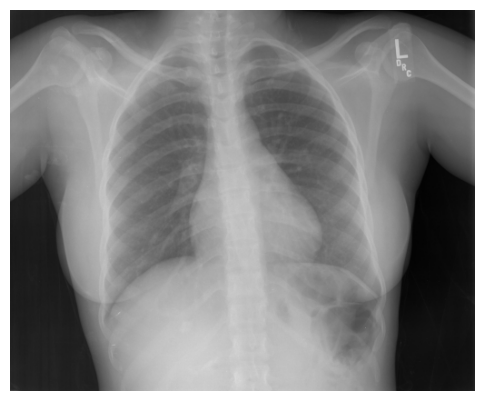

Image 1-2:
Describe the findings in X-ray images

the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. normal chest x-xxxx.


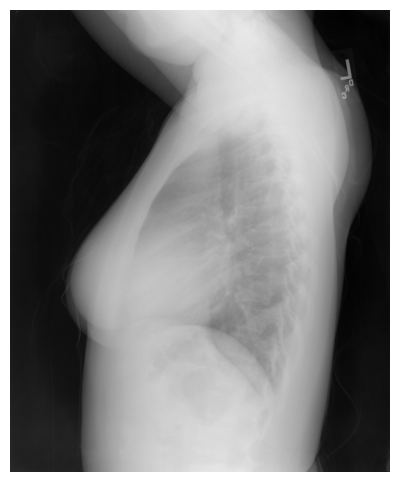

Image 2-1:
Describe the findings in X-ray images

no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified.


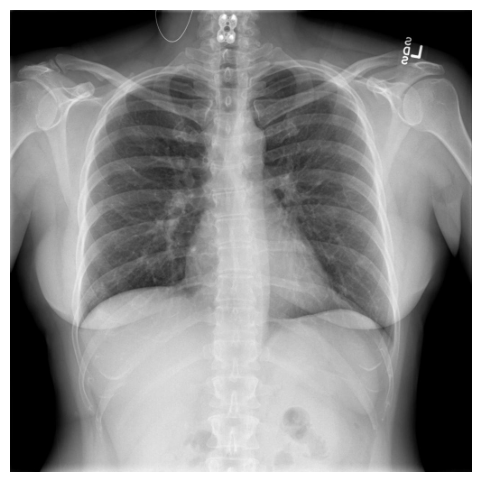

Image 2-2:
Describe the findings in X-ray images

no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified.


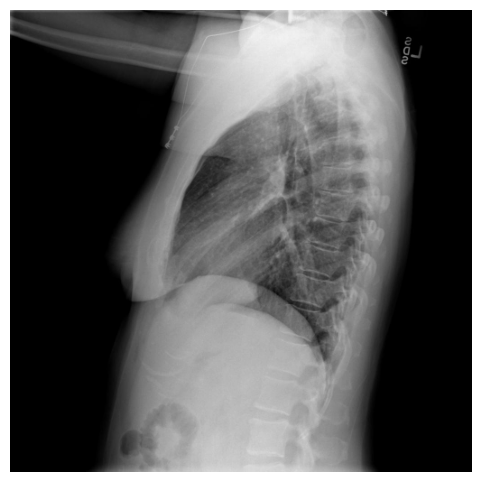

Image 3-1:
Describe the findings in X-ray images

the cardiac contours are normal. xxxx basilar atelectasis. the lungs are clear. thoracic spondylosis. lower cervical xxxx arthritis. basilar atelectasis. no confluent lobar consolidation or pleural effusion.


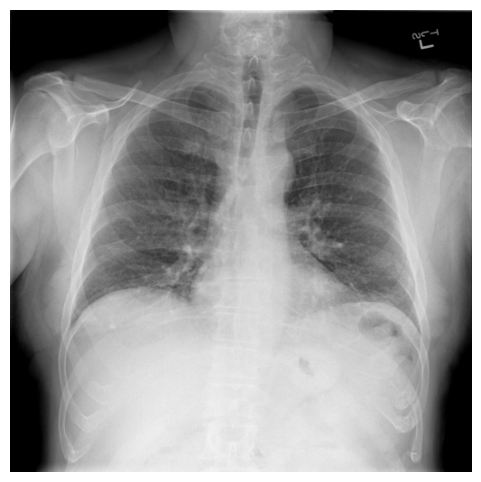

Image 3-2:
Describe the findings in X-ray images

the cardiac contours are normal. xxxx basilar atelectasis. the lungs are clear. thoracic spondylosis. lower cervical xxxx arthritis. basilar atelectasis. no confluent lobar consolidation or pleural effusion.


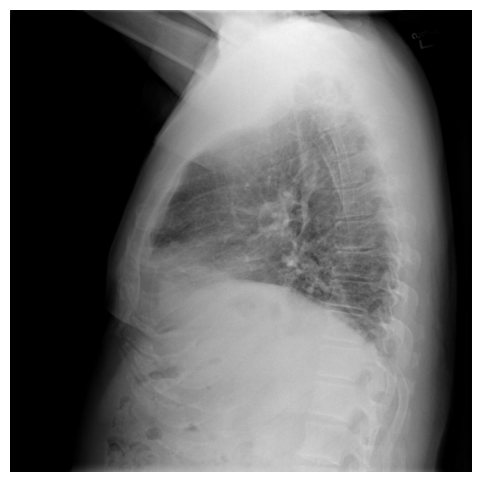

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Number of samples to visualize
num_samples = 3

for i in range(num_samples):
    # Retrieve images and label metadata
    image_pair, label = train_dataset[i]

    prefix = label["prefix"]
    suffix = label["suffix"]

    for idx, img in enumerate(image_pair):
        # Display image
        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')
        plt.axis("off")

        # Construct and print caption
        caption = f"Image {i+1}-{idx+1}:\n{prefix}\n\n{suffix}"
        print(caption)

        plt.show()


### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-224) checkpoint. Resolution has a key impact on the accuracy of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [10]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-224"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [12]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [13]:
# @title Freeze the image encoder

# TORCH_DTYPE = torch.bfloat16

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [14]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,044,118,768 || trainable%: 0.3901


### Fine-tune PaliGemma2 on JSON data extraction dataset

In [15]:
from transformers import Trainer, TrainingArguments


def collate_fn(batch):
    all_images = []
    all_texts = []
    suffixes = []

    for sample in batch:
        images, label = sample
        all_images.extend(images)
        suffixes.append(label["suffix"])

        image_tokens = " ".join(["<image>"] * len(images))
        all_texts.append(f"{image_tokens} Describe the findings from X-rays")

    inputs = processor(
        text=all_texts,
        images=all_images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs


args = TrainingArguments(
    num_train_epochs=20,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="/content/drive/MyDrive/paligemma2_object_detection",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)


In [ ]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Step,Training Loss
50,1.655600
100,1.559000
150,1.470300
200,1.500200
250,1.491700
300,1.380100
350,1.424800
400,1.357300
450,1.303600
500,1.310800


### Run inference with fine-tuned PaliGemma2 model

In [16]:
from transformers import AutoModelForSeq2SeqLM, AutoProcessor

# Path to saved model
MODEL_PATH = "/content/drive/MyDrive/paligemma2_object_detection/checkpoint-6000"

# Load model and processor
model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_PATH, device_map="auto")
print("✅ Model and processor loaded successfully!")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Model and processor loaded successfully!


### Evaluate fine-tuned PaliGemma2 model

In [17]:
import torch
import json
from tqdm import tqdm  # Import tqdm for progress bar

targets = []
predictions = []

# Use tqdm to show progress
with torch.inference_mode():
    for i in tqdm(range(len(test_dataset)), desc="Running Inference", unit="sample"):
        image_pair, label = test_dataset[i]  # Get image pair and label

        prefix = "<image> <image> Describe the findings from X-rays"
        suffix = label["suffix"]  # Ground-truth reference text

        inputs = processor(
            text=prefix,
            images=image_pair,  # Pass both images
            return_tensors="pt"
        ).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        # Generate text output
        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:].cpu()  # Move to CPU before decoding

        # Decode the generated text
        generated_text = processor.decode(generation, skip_special_tokens=True)

        # Store results
        targets.append(suffix)
        predictions.append(generated_text)

print("✅ Inference completed!")

# Print a few sample results
for i in range(3):  # Change as needed
    print(f"🔹 **Case {i+1}**")
    print(f"✅ **Ground Truth:** {targets[i]}")
    print(f"🤖 **Model Prediction:** {predictions[i]}")
    print("-" * 80)


Running Inference: 100%|██████████| 765/765 [4:02:39<00:00, 19.03s/sample]

✅ Inference completed!
🔹 **Case 1**
✅ **Ground Truth:** there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. there are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.there are streaky opacities in the right upper lobe, xxxx scarring. the cardiomediastinal silhouette is normal in size and contour. there is no pneumothorax or large pleural effusion. 1. bullous emphysema and interstitial fibrosis. 2. probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or ct thorax to document resolution.
🤖 **Model Prediction:** the heart is large. the pulmonary xxxx are engorged. aorta is thickened and tortuous. atherosclerotic calcifications are present. a right upper abdominal pleura

**NOTE:** BLEU (Bilingual Evaluation Understudy) is a metric used to measure the similarity between a VLM's generated text (like a caption for an image) and a human-written reference text. It works by calculating the overlap of words and phrases, giving a score between 0 and 1.  A higher BLEU score indicates better agreement between the generated text and the reference, meaning the VLM is doing a better job of producing expected output.

In [18]:
# @title Calculate BLEU

from evaluate import load

bleu = load("bleu")

results = bleu.compute(predictions=predictions, references=targets)
print(results)

{'bleu': 0.026190989381907344, 'precisions': [0.09550538755851902, 0.0357609501724483, 0.016382781229861476, 0.008409749608020146], 'brevity_penalty': 1.0, 'length_ratio': 4.933258180136432, 'translation_length': 170671, 'reference_length': 34596}


**NOTE:** Translation Error Rate (TER) is another metric used to evaluate machine translation, often applied to VLMs that generate text. Unlike BLEU, which focuses on overlap, TER calculates the number of edits (insertions, deletions, substitutions, shifts) needed to change the generated text into a human-written reference.

In [19]:
# @title Calculate TER

from evaluate import load

ter = load("ter")
results = ter.compute(predictions=predictions, references=targets, case_sensitive=True)
print(results)

{'score': 442.7745465808583, 'num_edits': 128657, 'ref_length': 29057.0}
